# COM4509/6509 MLAI - Assignment Part 2 Brief

## Deadline: Friday, December 3, 2021 at 15:00 hrs

## Scope: Sessions 6 to 8

## Number of marks available for Part 2: 25

### Please READ the whole assignment first, before starting to work on it.

### How and what to submit

1. A Jupyter Notebook with the code in all the cells executed, outputs displayed, and code
documented.

2. Name your Notebook as COM4509-6509_Assignment_Part2_Username_XXXXXX.ipynb where XXXXXX is your username such as abc18de.

3. Upload a .zip file to Blackboard before the deadline that contains two Jupyter Notebooks, one for Part 1 and one for Part 2 (COM4509-6509_Assignment_Part1_Username_XXXXXX.ipynb and COM4509-6509_Assignment_Part2_Username_XXXXXX.ipynb)

4. NO DATA UPLOAD: Please do not upload the data files used in this Notebook. We have a copy already. Instead, please use a relative file path in your code (data files under folder ‘data’), as in the lab notebook so that we can run your code smoothly when needed. So ‘./data/’, instead of ‘/User/username/myfiles/mlai/assignment1/’

### Assessment Criteria

1) Being able to build complete, reproducible machine learning pipelines from loading data to evaluating prediction performance.

2) Being able to design different machine learning models to compare/optimise prediction performance.

3) Being able to perform exploratory data analysis to gain insights.

## A. Reproducibility & readability

In [1]:
import sys
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import medmnist
from medmnist import INFO, Evaluator
%matplotlib inline


# Set a random seed for reproducibility
np.random.seed(210169508)
torch.manual_seed(210169508)

## B. Logistic Regression on BreastMNIST [9 marks]

The first version of the MedMNIST, published in ISBI21 (2010.14925.pdf (arxiv.org)). As taken from the paper: BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign and malignant originally but in BreastMNIST, the task is simplified into binary classification by combining normal and benign as positive, and classifying them against malignant as negative. The source dataset with a ratio of 7 : 1 : 2 into training, validation and test set. The source images of 1 × 500 × 500 are resized into 1 × 28 × 28.

We aim to train a L2-regularised logistic regression model to classify the two classes in BreastMNIST using the standard train/validation/test split with decent performance, i.e. much better than the chance level at worst.

### B1 Data loading and inspection [3 mark]

Follow instructions at https://github.com/MedMNIST/MedMNIST to download and load the data. Display at least ten images for each class, i.e. at least 20 images, from the training set. Display at least ten images for each class from the validation set, and display at least ten images for each class from the test set.


In [2]:
# ------ My answer of B1 ------ #
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 10 # Set epochs
BATCH_SIZE = 64 # Set batch
lr = 0.001 # Set learning rate

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels'] # 1 channel
n_classes = len(info['label']) # 2 classes
print("The type of this dataset is:", task)
print("It has ", n_channels, " channel")
print("The label of the dataset is: ", info['label'])

DataClass = getattr(medmnist, info['python_class'])

# Preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load the data
train_dataset = DataClass(root='./data', split='train', transform=data_transform, download=download) # 546
val_dataset = DataClass(root='./data', split='val', transform=data_transform, download=download)     # 78
test_dataset = DataClass(root='./data', split='test', transform=data_transform, download=download)   # 156

# Encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# visualization
def class_count(dataset):
    normal_benign_count = 0
    malignant_count = 0

    for i in dataset.labels:
        if i[0] == 1:
            normal_benign_count += 1
            
        elif i[0] == 0:
            malignant_count += 1
    # print(dataset.imgs.shape) (546, 28, 28) (78, 28, 28) (156, 28, 28)
    print("There are", normal_benign_count, "normal or benign imgs and", malignant_count, "malignant imgs in the", dataset.split, "dataset")

class_count(train_dataset)      
class_count(val_dataset)
class_count(test_dataset)

The type of this dataset is: binary-class
It has  1  channel
The label of the dataset is:  {'0': 'malignant', '1': 'normal, benign'}
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
There are 399 normal or benign imgs and 147 malignant imgs in the train dataset
There are 57 normal or benign imgs and 21 malignant imgs in the val dataset
There are 114 normal or benign imgs and 42 malignant imgs in the test dataset


# ------ Below we display two classes images from the training set ------ #
There are 19 malignant images in this batch.


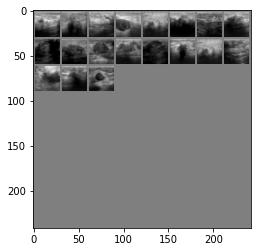

There are 45 normal or benign images in this batch.


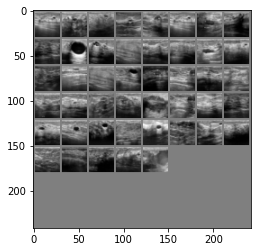

# ----- Below we display two classes images from the validation set ----- #
There are 15 malignant images in this batch.


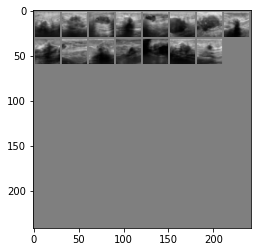

There are 49 normal or benign images in this batch.


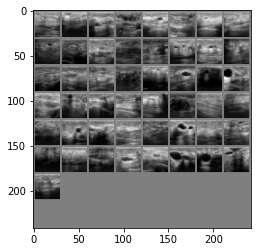

# -------- Below we display two classes images from the test set -------- #
There are 20 malignant images in this batch.


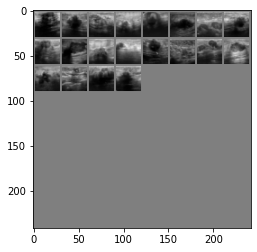

There are 44 normal or benign images in this batch.


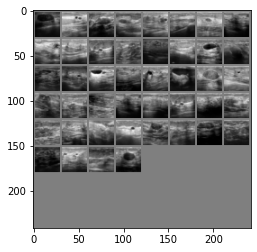

End of question B1 [3 marks].


In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def display_img(dataloader):
    dataiter = iter(dataloader) # Get some random images
    images, labels = dataiter.next() # Get one batch (64 here)

    empty_0 = torch.zeros(images.shape) # Set up an empty torch to store imgs for class 0
    empty_1 = torch.zeros(images.shape) # Set up an empty torch to store imgs for class 1

    nor_ben_index = -1
    mali_index = -1
    index = -1

    for i in labels:
        index += 1
        if i[0] == 0:
            mali_index += 1
            empty_0[mali_index] = images[index] # Store class 0 images in empty_0
        
        elif i[0] == 1:
            nor_ben_index += 1
            empty_1[nor_ben_index] = images[index] # Store class 1 images in empty_1

    print("There are", mali_index+1, "malignant images in this batch.")
    imshow(torchvision.utils.make_grid(empty_0))
    print("There are", nor_ben_index+1, "normal or benign images in this batch.")
    imshow(torchvision.utils.make_grid(empty_1))

print("# ------ Below we display two classes images from the training set ------ #")
display_img(train_loader)
print("# ----- Below we display two classes images from the validation set ----- #")
display_img(val_loader)
print("# -------- Below we display two classes images from the test set -------- #")
display_img(test_loader)
print("End of question B1 [3 marks].")

### B2 Logistic regression [4 marks]

Keep a record of the three metrics M1 to M3 below for the two models below:
* M1) Training accuracy: the prediction accuracy of a trained model on the training dataset.
* M2) Validation accuracy: the prediction accuracy of a trained model on the validation dataset.
* M3) Testing accuracy: the prediction accuracy of a trained model on the test dataset.

**a.** Using the built-in logistic regression functions in scikit-learn, train a logistic regression model with L2 regularisation on the training set, use the validation set to choose a good regularisation parameter (a hyperparameter) from at least three choices, and test the chosen model on the test set. Report the three metrics M1 to M3 **[2 marks]**

**b.** Using PyTorch (see Question 5 of Lab 6), train a logistic regression model with L2 regularisation on the training set, use the validation set to choose a good regularisation parameter (a hyperparameter) from at least three choices, and test the chosen model on the test set. Report the three metrics M1 to M3 **[2 marks]**

In [4]:
# ------ My answer of B2a ------ #
X_train = np.array([img.numpy().flatten() for img, label in train_dataset]) # 546 x 784
y_train = np.array([label for img, label in train_dataset]).ravel()         # (546,)

X_val = np.array([img.numpy().flatten() for img, label in val_dataset])     # 78 x 784
y_val = np.array([label for img, label in val_dataset]).ravel()             # (78,)

X_test = np.array([img.numpy().flatten() for img, label in test_dataset])   # 156 x 784
y_test = np.array([label for img, label in test_dataset]).ravel()           # (156,)

M1a = 0
M2a = 0
M3a = 0
def metrics_report(reg_strength):
    
    # Regularization strength C is a hyperparameter, I will change it for at least 3 times
    my_model = LogisticRegression(penalty='l2', C=reg_strength, solver='lbfgs', max_iter = 800)
    my_model.fit(X_train, y_train)
    
    train_pred = my_model.predict(X_train)
    val_pred = my_model.predict(X_val)
    test_pred = my_model.predict(X_test)
    
    M1a = accuracy_score(y_train, train_pred)
    M2a = accuracy_score(y_val, val_pred)
    M3a = accuracy_score(y_test, test_pred)

    return {
        'M1 Training accuracy': M1a,
        'M2 Validation accuracy': M2a,
        'M3 Testing accuracy': M3a,
    }

# Firstly, set the regularization strength C = 10.0
print("regularization strength C = 10.0")
metrics_report(reg_strength=10.0)

regularization strength C = 10.0


{'M1 Training accuracy': 0.9981684981684982,
 'M2 Validation accuracy': 0.8589743589743589,
 'M3 Testing accuracy': 0.7564102564102564}

In [5]:
print("regularization strength C = 5")
metrics_report(reg_strength=5)

regularization strength C = 5


{'M1 Training accuracy': 0.9981684981684982,
 'M2 Validation accuracy': 0.8333333333333334,
 'M3 Testing accuracy': 0.7628205128205128}

In [6]:
print("regularization strength C = 1.0")
metrics_report(reg_strength=1.0)

regularization strength C = 1.0


{'M1 Training accuracy': 0.9487179487179487,
 'M2 Validation accuracy': 0.8461538461538461,
 'M3 Testing accuracy': 0.8205128205128205}

In [7]:
print("regularization strength C = 0.5")
metrics_report(reg_strength=0.5)

regularization strength C = 0.5


{'M1 Training accuracy': 0.9120879120879121,
 'M2 Validation accuracy': 0.8461538461538461,
 'M3 Testing accuracy': 0.7948717948717948}

In [8]:
print("regularization strength C = 0.1")
metrics_report(reg_strength=0.1)
print("# ----- End of question B2a ----- #")

regularization strength C = 0.1
# ----- End of question B2a ----- #


In [19]:
# ------ My answer of B2b ------ #
NUM_EPOCHS = 10                  # Set epochs
BATCH_SIZE = 64                  # Set batch
lr = 0.001                       # Set learning rate
n_classes = len(info['label'])   # 2 classes {0, 1}
input_dim = 784                  # 28*28

M1b = 0
M2b = 0
M3b = 0

class LogisticRegression(nn.Module):
    # input_dim = 28*28, n_classes = 2
    def __init__(self, input_dim, n_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, n_classes)
        
    def forward(self, x):    
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred
    
LR = LogisticRegression(input_dim, n_classes)
print(LR)

def metrics_report_2(model, optimizer):
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(NUM_EPOCHS):
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images.view(-1, input_dim)) # torch.Size([64, 784])            
            labels = Variable(labels)                     # torch.Size([64, 1])
            labels = torch.squeeze(labels)                # torch.Size([64])
                           
            optimizer.zero_grad()
            outputs = model(images)                       # torch.Size([64, 2])
                        
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    

    # M1 Training accuracy = M1b
    correct_train = 0
    total_train = 0
    for images, labels in train_loader_at_eval:
        images = Variable(images.view(-1, input_dim))
        labels = torch.squeeze(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)        
        
        correct_train += (predicted == labels).sum()
        total_train += labels.size(0)
                
    M1b = correct_train / total_train
    print("Trained", int(total_train), "images in training set.", int(correct_train),"of them were predicted correct, and M1 is", float(M1b))

    
    # M2 Training accuracy = M2b
    correct_val = 0
    total_val = 0
    for images, labels in val_loader:
        images = Variable(images.view(-1, input_dim))
        labels = torch.squeeze(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)        
        
        correct_val += (predicted == labels).sum()
        total_val += labels.size(0)
                
    M2b = correct_val / total_val
    print("Validated", int(total_val), "images in val set.", int(correct_val),"of them were predicted correct, and M2 is", float(M2b))
    

    # M3 Testing accuracy = M3b
    correct_test = 0
    total_test = 0
    for images, labels in test_loader:
        images = Variable(images.view(-1, input_dim))
        labels = torch.squeeze(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        correct_test += (predicted == labels).sum()
        total_test += labels.size(0)
    
    M3b = correct_test / total_test
    print("Test", int(total_test), "images in test set.", int(correct_test),"of them were predicted correct, and M3 is", float(M3b))

    return(M1b, M2b, M3b)

optimizer_L2 = torch.optim.SGD(LR.parameters(), lr=lr, weight_decay = 0.001)
(M1b, M2b, M3b) = metrics_report_2(LR, optimizer_L2)

LogisticRegression(
  (linear): Linear(in_features=784, out_features=2, bias=True)
)
Trained 546 images in training set. 384 of them were predicted correct, and M1 is 0.7032967209815979
Validated 78 images in val set. 57 of them were predicted correct, and M2 is 0.7307692170143127
Test 156 images in test set. 113 of them were predicted correct, and M3 is 0.7243589758872986


### B3 Performance comparison (2 marks)

**a.** Summarise each of the three metrics from the two models in B2 using one or more bar graphs. **[1 mark]**

**b.** Describe at least two observations interesting to you. **[1 mark]**

In [ ]:
# ------ My answer of B3a ------ #

In [13]:
print("# ------ My answer of B3b ------ #")

# ------ My answer of B3b ------ #


For question B2a using scikit-learn:
* I choose more than 10 Regularization Strength value to observe, and choose 5 values as specific examples (e.g. 10, 5, 1, 0.5, 0.1).
* As the value of c decreases, M1 Training accuracy tends to decrease, from 0.998 to 0.857. That is smaller C values specify stronger regularization.
* As the value of c decreases, M2 Validation accuracy behaves steadily, fluctuating between 0.833 and 0.859.
* M3 has the highest accuracy and performs best when c takes the default value (i.e. is 1). It may be that scikit-learn is better optimised for default values.

## C. Convolutional Neural Networks on OCTMNIST [8 marks]

OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases, with 4 different types, leading to a multi-class classification task. The source training set is split with a ratio of 9 : 1 into training and validation sets, and uses its source validation set as the test set. The source images are single channel, and their sizes are (384−1, 536)×(277−512), which are center-cropped and resized to 1 × 28 × 28.

### C1 Data loading and inspection [2 mark]

Follow instructions at https://github.com/MedMNIST/MedMNIST to download and load the data. Display at least ten images for each class, i.e. at least 40 images, from the training set.

### C2 Convolutional neural networks [4 marks]

Keep a record of the four metrics M1 to M4 below for the two models below:
* M1) Training accuracy: the prediction accuracy of a trained model on the training dataset. 
* M2) Validation accuracy: the prediction accuracy of a trained model on the validation dataset. 
* M3) Testing accuracy: the prediction accuracy of a trained model on the test dataset.
* M4) Training time: the time taken to train the model (i.e. to learn/estimate the learnable parameters) on the training dataset.

This question asks you to design convolutional neural networks (CNNs). Only the number of convolutional (Conv) layers and the number of fully connected (FC) layers will be specified below. You are free to design other aspects of the network. For example, you can use other types of operation (e.g. padding), layers (e.g. pooling, or preprocessing (e.g. augmentation), and you choose the number of units/neurons in each layer. Likewise, you may choose the number of epochs and many other settings according to your accessible computational power.

**a.** Design a CNN with two Conv layers and two FC layers. Train the model on the training set, use the validation set to choose the best design among at least three different choices, and test the chosen model on the test set. Report the four metrics M1 to M4 **[2 marks]**

**b.** Design a CNN with three Conv layers and three FC layers. Train the model on the training set, use the validation set to choose the best design among at least three different choices, and test the chosen model on the test set. Report the four metrics M1 to M4 **[2 marks]**

### C3 Performance comparison (2 marks)

**c.** Summarise each of the four metrics from the two models in B2 using one or more bar graphs. **[1 mark]**

**d.** Describe at least two observations interesting to you. **[1 mark]**

## D. Unsupervised learning on Fashion-MNIST [8 marks]

Fashion-MNIST is a dataset of Zalando's article images, with examples shown above. It consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes: 0=T-shirt/top; 1=Trouser; 2=Pullover; 3=Dress; 4=Coat; 5=Sandal; 6=Shirt; 7=Sneaker; 8=Bag; 9=Ankle boot.

Choose any two out of the 10 classes and use only the test data for these two chosen classes to complete tasks in this section. It will be better to finish reading the remaining part of this section before choosing the two classes. Again, you may choose any two and there is no “correct” answer about which two to choose but some choices may make your studies below more interesting than others.

Use the PyTorch API for Fashion-MNIST to load the training/test data of Fashion-MNIST. You may refer to similar procedures in Lab 7 for CIFAR-10.

### D1. Dimensionality reduction and clustering [7 marks]

**a.** Apply PCA to all images of these two chosen classes. Visualise the top 5 eigenvectors as images and display them in the order of descending corresponding values (the one corresponding to the largest eigenvalue first). **[1 marks]**

**b.** Use the top 30 PCs to reconstruct 10 images, with 5 from each class (any 5 images are fine from each class). Show these 10 pairs of reconstructed and original images. **[1 marks]**
    
**c.** Visualise the two-dimensional PCA representations of all data points in a 2D plane (i.e. using the top two PCs). Use different colours/markers for the two classes for better visualisation (Hint: You need to use the class labels here for visualisation). **[1 marks]**

**d.** Use spectral clustering to cluster all data points as represented by the top two PCs (clustering of two-dimensional vectors, where each vector has two values, PC1 and PC2). Visualise the two clusters with different colours/markers in 2D. **[2 marks]**

**e.** Design a new autoencoder with five Conv2d layers and five ConvTranspose2d layers. You are free to choose the activation functions and settings such as stride and padding. Train this new autoencoder on all images of these two chosen classes for at least 20 epochs. Plot the loss against the epoch. **[2 marks]**

### D2 Observation [1 marks]

Describe at least two observations interesting to you from D1 above.

## The END of Assignment

---